In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def f(x):
  return 3*x**2 - 4*x + 5

In [20]:
f(3)

20

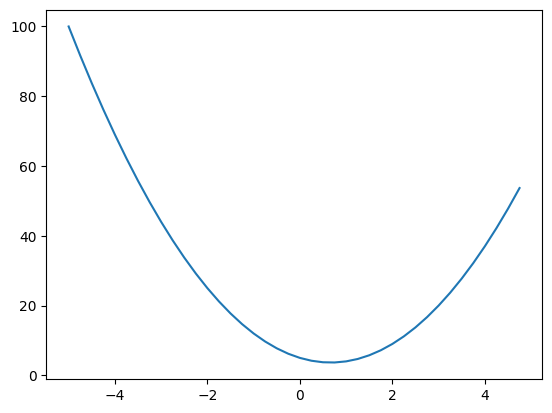

In [21]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [22]:
# Calculating the gradient at x, h is the change
x = 2/3
h = 0.0001
# Derivative - change in x over change itself - rise/run
(f(x+h)-f(x))/h

0.0002999999981767587

# Create Value Class

In [23]:
class Value():
  def __init__(self, data, _children=(), _op='', label = ""):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label # Store label from constructor

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other) # Fix: Reassign other
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      # Calc power rule + chain rule
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      # derivative of e^x is e^x
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):
    # Topological Sort

    topo = []
    # Maintain a set of visited nodes starting at root node
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        # Goes through all the children and adds it to itself
        for child in v._prev:
          build_topo(child)
        # added once all children are in the list
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [24]:
a = Value(2.0, label='a')
b = Value(4.0, label='b')

a / b

Value(data=0.5)

# Create Digraph

In [25]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [26]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'



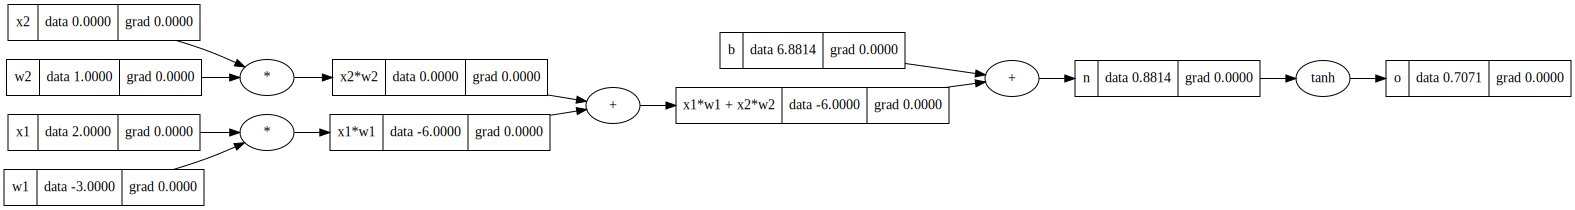

In [27]:
draw_dot(o)

# Neural Net Class

In [28]:
import random
import math

# -----------------------------------------------------------------------------
# 1. THE NEURON
# A single unit that takes inputs, weighs them, adds a bias, and fires.
# -----------------------------------------------------------------------------
class Neuron:
  def __init__(self, nin):
    """
    Initializes a single Neuron.

    Args:
        nin (int): "Number of Inputs". The size of the input vector coming into this neuron.
                   (e.g., if the previous layer has 10 neurons, nin is 10).
    """
    # Create a list of 'nin' weights.
    # We use list comprehension [ ... for _ in range(nin)] to create the list.
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]

    # Create a single bias.
    # This controls the "trigger happiness" of the neuron.
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    """
    The Forward Pass. Calculates the output when given an input vector x.
    Formula: output = tanh(sum(weights * inputs) + bias)
    """
    # 1. zip(self.w, x): Pairs up each weight with its corresponding input.
    #    Example: [(w0, x0), (w1, x1), ...]
    # 2. wi*xi: Multiplies the pairs (element-wise multiplication).
    # 3. sum(..., self.b): Sums up all the multiplications AND adds the bias at the end.
    #    Note: Passing self.b as the second argument to sum() ensures we start the sum with the bias
    #    instead of 0 (which avoids the integer + Value error we discussed earlier).
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)

    # Apply the non-linearity (activation function).
    # This squishes the result to be between -1 and 1.
    out = act.tanh()

    return out

  def parameters(self):
    """
    Returns a list of all learnable parameters in this neuron.
    Used later by the optimizer to update them (nudge them to lower loss).
    """
    # Returns [w1, w2, w3, ..., b]
    return self.w + [self.b]


# -----------------------------------------------------------------------------
# 2. THE LAYER
# A vertical stack of Neurons acting in parallel.
# -----------------------------------------------------------------------------
class Layer:
  def __init__(self, nin, nout):
    """
    Initializes a Layer of neurons.

    Args:
        nin (int): Number of inputs coming INTO this layer.
        nout (int): Number of neurons IN this layer (the output size).
    """
    # Creates 'nout' independent Neurons.
    # Each neuron expects 'nin' inputs.
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    """
    Passes the input vector x through every neuron in this layer independently.
    """
    # Calculate output for every single neuron.
    outs = [n(x) for n in self.neurons]

    # Convenience check:
    # If there is only 1 neuron (like in the final output layer), return just the Value.
    # Otherwise, return the list of Values.
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    """
    Collects parameters from ALL neurons in this layer.
    """
    # A nested list comprehension:
    # "For every neuron in this layer, get its parameters, and put them all in one big list."
    return [p for neuron in self.neurons for p in neuron.parameters()]


# -----------------------------------------------------------------------------
# 3. THE MLP (Multi-Layer Perceptron)
# The full network, consisting of a sequence of Layers.
# -----------------------------------------------------------------------------
class MLP:
  def __init__(self, nin, nouts):
    """
    Initializes the entire neural network.

    Args:
        nin (int): The number of inputs into the very first layer.
        nouts (list of int): A list defining the size of all subsequent layers.
                             Example: [16, 16, 1] means two hidden layers of 16 and one output of 1.
    """
    # Combine the input size with the layer sizes list.
    # Example: if nin=3 and nouts=[4, 4, 1], then sz becomes [3, 4, 4, 1].
    sz = [nin] + nouts

    # Create the layers.
    # We loop through the sizes and connect them.
    # Layer 0: connects sz[0] -> sz[1] (3 -> 4)
    # Layer 1: connects sz[1] -> sz[2] (4 -> 4)
    # Layer 2: connects sz[2] -> sz[3] (4 -> 1)
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    """
    Passes the input x sequentially through each layer.
    """
    # Take input x, pass it through layer 0.
    # Take that result, pass it through layer 1.
    # Repeat until the end.
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    """
    Collects parameters from the ENTIRE network.
    This gives us one giant list of every single weight and bias in the MLP.
    """
    return [p for layer in self.layers for p in layer.parameters()]




In [29]:
x = [2.0, 3.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.36073442750367046)

In [30]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [31]:
for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)


0 5.820994586026522
1 3.2257068643803524
2 3.7706253228906657
3 2.6883787896975173
4 0.6982703366881284
5 0.2270224533958875
6 0.10421048228782215
7 0.07034547755081061
8 0.05465363671281909
9 0.04491049354757343
10 0.03813314931540494
11 0.03311525461642549
12 0.029243144019252744
13 0.026163197443653023
14 0.023654992515341255
15 0.02157331109468759
16 0.019818372162513462
17 0.018319278435558695
18 0.017024246345621226
19 0.01589456405750435


In [32]:
ypred

[Value(data=0.9294163049766765),
 Value(data=-0.9575968383870946),
 Value(data=-0.9445121387030906),
 Value(data=0.922311035608115)]

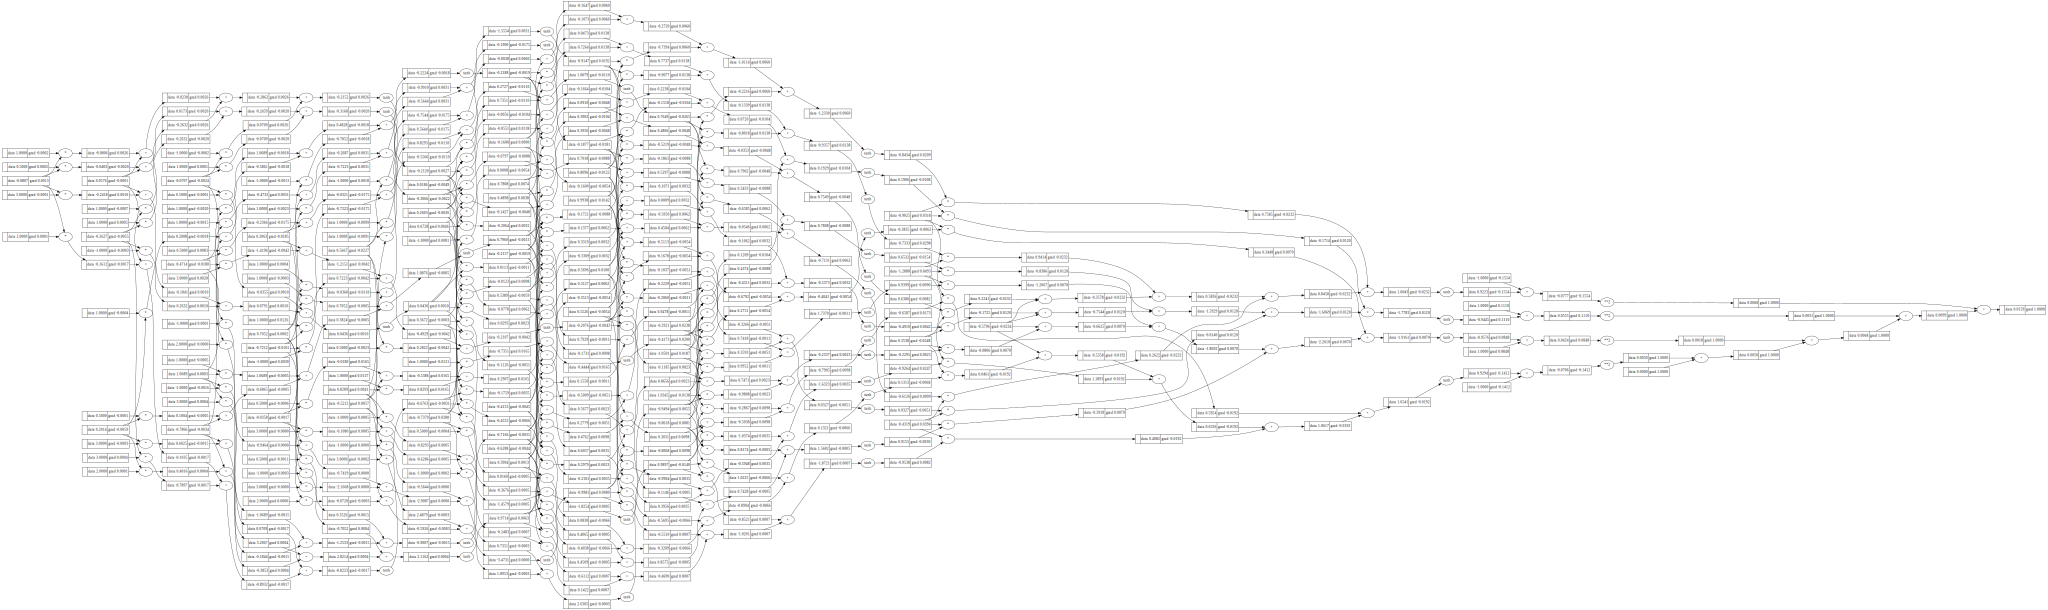

In [33]:
draw_dot(loss)